In [1]:
#data = pd.read_parquet('bedmap_train.parquet', engine='fastparquet') #Full data read.

import pyarrow.parquet as pq
import pandas as pd
import random

#Only loading 1% of data
# Open the Parquet file
parquet_file = pq.ParquetFile('bedmap_train.parquet')

# Get number of row groups
num_row_groups = parquet_file.num_row_groups

# Select 1% of row groups randomly
sample_size = max(1, int(num_row_groups * 0.01))
selected_groups = random.sample(range(num_row_groups), sample_size)

# Read only the selected row groups
dfs = []
for i in selected_groups:
    table = parquet_file.read_row_group(i)
    df = table.to_pandas()
    dfs.append(df)

# Combine into one DataFrame
data = pd.concat(dfs, ignore_index=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048576 entries, 0 to 1048575
Data columns (total 11 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   LON       1048576 non-null  float64
 1   LAT       1048576 non-null  float64
 2   THICK     1048576 non-null  float64
 3   geometry  1048576 non-null  object 
 4   EAST      1048576 non-null  float64
 5   NORTH     1048576 non-null  float64
 6   v         1048576 non-null  float64
 7   ith_bm    1048576 non-null  float64
 8   smb       1048576 non-null  float64
 9   z         1048576 non-null  float64
 10  s         1048576 non-null  float64
dtypes: float64(10), object(1)
memory usage: 88.0+ MB


In [5]:
import matplotlib.pyplot as plt
from tqdm import tqdm

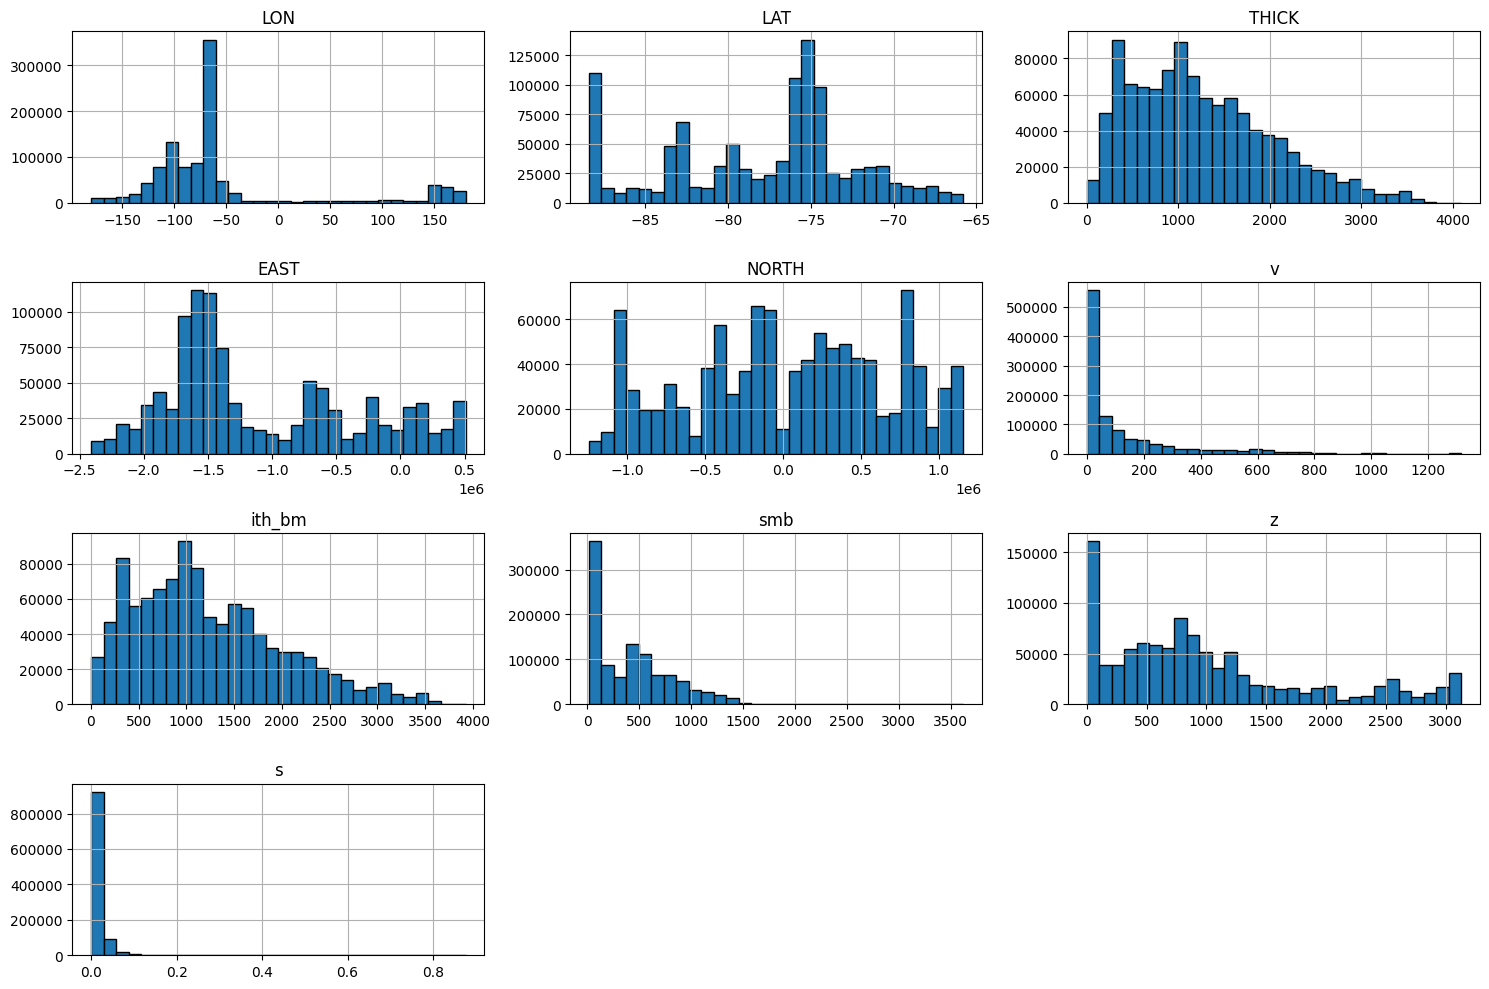

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Set the figure size
data.hist(bins=30, figsize=(15, 10), edgecolor='black')
plt.tight_layout()
plt.show()

In [31]:
# Read the data and print the variables:
variables = data.columns
print(variables.values)

# Decide on which variables to use for input (X) and what defines the label (Y):
input_variables = variables[(variables != 'ith_bm') & (variables != 'LON') & (variables != 'LAT') & (variables != 'geometry') & (variables != 'THICK')]
input_data      = data[input_variables]
truth_data      = data['THICK']
benchmark_data  = data['ith_bm']
print("  Variables used for training: ", input_variables.values)

['LON' 'LAT' 'THICK' 'geometry' 'EAST' 'NORTH' 'v' 'ith_bm' 'smb' 'z' 's']
  Variables used for training:  ['EAST' 'NORTH' 'v' 'smb' 'z' 's']


In [33]:
#We start by wanting to use a Boosted Descision Tree:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
import lightgbm as lgb
from lightgbm import early_stopping
import time
input_train, input_test, truth_train, truth_test, benchmark_train, benchmark_test = \
    train_test_split(input_data, truth_data, benchmark_data, test_size=0.25, random_state=42)

# Feed the datasets to LightGBM:
lgb_train = lgb.Dataset(input_train, truth_train)
lgb_eval  = lgb.Dataset(input_test,  truth_test, reference=lgb_train)

In [35]:
# Set parameters for LightGBM (known more generally as "hyper parameters"):
params = {
    'boosting_type': 'gbdt', 
    'learning_rate': 0.1,     
    'num_leaves': 6,         
    'num_trees': 100,
    'min_data_in_leaf': 20,  
    'objective': 'mean_absolute_error',   # The outcome is binary, b-quark or not
    'verbose': 1,            # Level of output. Can be set to -1 to suppress the output
}

# We track the time it takes to train the model:
start=time.time()

# Train the model:
gbm = lgb.train(params,                             # General settings (defined above)
                lgb_train,                          # Data to use for training
                num_boost_round=1000,               # How many rounds for training
                valid_sets=lgb_eval,                # Data to use for validation
                callbacks=[early_stopping(20)])     # Stops if no improvement is seen in N=20 rounds.
 
# Print the time usage:
end = time.time()
print(f"\nTime used by LightGBM: {(end-start):.1f} s")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.046077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 786432, number of used features: 6
[LightGBM] [Info] Start training from score 1118.540039
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 159.879

Time used by LightGBM: 7.4 s


c:\users\adian\applied machine learning course\appmlenv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


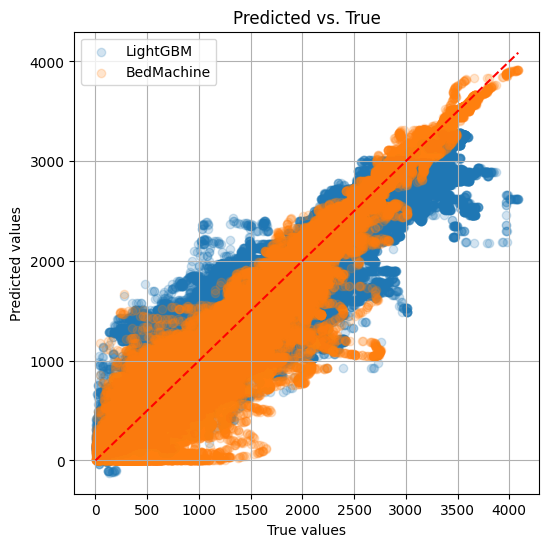

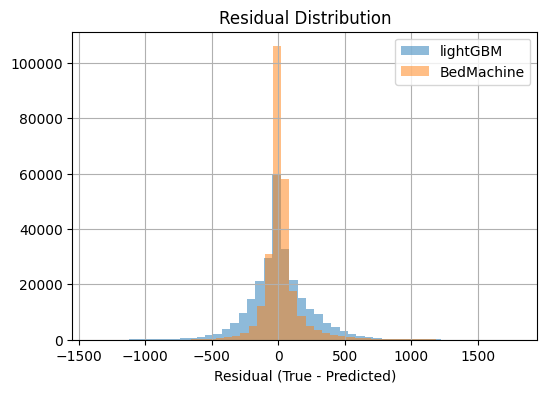

Mean Absolute Error (MAE) LIGHTGBM: 159.8786
Mean Absolute Error (MAE) BedMachine: 81.2041


In [55]:
# Scatter plot: predicted vs true
truth_score = gbm.predict(input_test, num_iteration=gbm.best_iteration)  # Scores
plt.figure(figsize=(6, 6))
plt.scatter(truth_test, truth_score, alpha=0.2, label='LightGBM')
plt.scatter(truth_test, benchmark_test, alpha=0.2, label='BedMachine')
plt.plot([truth_test.min(), truth_test.max()], [truth_test.min(), truth_test.max()], 'r--')  # Ideal line
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predicted vs. True')
plt.legend()
plt.grid(True)
plt.show()

# Residual plot: true - predicted
residuals = truth_test - truth_score
residualsbenchmark = truth_test - benchmark_test
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=50, alpha=0.5, label='lightGBM')
plt.hist(residualsbenchmark, bins=50, alpha=0.5, label='BedMachine')
plt.xlabel("Residual (True - Predicted)")
plt.title("Residual Distribution")
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(truth_test, truth_score)
maebenchmark = mean_absolute_error(truth_test, benchmark_test)
print(f"Mean Absolute Error (MAE) LIGHTGBM: {mae:.4f}")
print(f"Mean Absolute Error (MAE) BedMachine: {maebenchmark:.4f}")

Correlated data:

Normalize data to avoid correlation.
How do we figure out if points are correlated or not.

BDT gives error around 83 meters 

Shouldconsider Bedmapmachine as a compeditor. You can also use it as an additional input if you want (though redifine the target as the depth divided by the Beddepth. The ratio will be around 1 which is a normalization for the neural network. Con: You become interdependent of updates of the Bedmachine model and you may inherit the errors of the bedmachine model. 

The points chosen must cover antartica (representative), maybe reweighting data thicknesses that are less occuring (this is likely not a problem though) and get uncorrelated points.

Max thickness is 4500 meters.

Another idea is pixelating (average in grid and so we can get a complete covering).


Making test dataset of uncorrellated: Take a chunk out of map, train on everything else and test on chunck. Most of the chunck will be uncorrelated to the rest.

11x11 center point is where thickness was measured.

Try to introduce new datasets like temperature.

GNN: Connect datapoints through flow of ice.

Flow makes sense to make big images in CNN since information far away is relevant.

For Nans in map put 0. 

Start with one map, and add more later if you can get some 

That model can also be used to filter for bad measurements out.



Questions to Niccolo:
CNN